# IRAC forced photometry using tractor
### following Kristina Nylands script

modified notebook for speedup

In [24]:
import math
import time
import warnings
import concurrent.futures

import sys
import os
from contextlib import contextmanager

import numpy as np

try:
    import pandas as pd
except ImportError:
    !{sys.executable} -m pip install -U pandas

import pandas as pd

import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    !{sys.executable} -m pip install -U seaborn
    
import seaborn as sns

try: 
    import statsmodels
except ImportError:
    !{sys.executable} -m pip install -U statsmodels
import statsmodels

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats
import astropy.wcs as wcs
import astropy.io.fits as fits

try:
    from reproject import reproject_interp
except ImportError:
    !{sys.executable} -m pip install -U reproject

from reproject import reproject_interp

from skimage.transform import rotate

from tractor import (Tractor, PointSource, PixPos, Flux, PixelizedPSF, NullWCS,
                     NullPhotoCal, ConstantSky, Image)


sys.path.append('/home/jkrick/fornax-demo-notebooks/code/')
from determine_source_type import determine_source_type
from extract_cutout import extract_cutout
from find_nconfsources import find_nconfsources
from display_images import display_images
from plot_SED import plot_SED
#from prepare_prf import prepare_prf

set up clean catalog with fiducial band fluxes, ra, dec, shape parameters, probability that it is a star

In [2]:
#read in the catalog I generated from IRSA website
#COSMOS 2015 with only some of the columns and a few rows
#Type: 0 = galaxy, 1 = star, 2 = X-ray source
#I think the center of this catalog is roughy 149.955, 3.5375
df = pd.read_csv('/home/jkrick/fornax-demo-notebooks/data/table_irsa_catalog_search_results.csv')

# set default cutout width = 10"
cutout_width = 10

ra_0 = df.ra[0]
dec_0 = df.dec[0]

In [3]:
#are there missing values
df.isna().sum()

#don't mind that there are missing values for IRAC flues or for photzs.  
#The rest of the rows are complete

ra                     0
dec                    0
ks_flux_aper2          0
ks_fluxerr_aper2       0
splash_1_flux          0
splash_1_flux_err      0
splash_2_flux          4
splash_2_flux_err      4
splash_3_flux          1
splash_3_flux_err      1
splash_4_flux          1
splash_4_flux_err      1
photoz               103
type                   0
dist                   0
angle                  0
dtype: int64

In [4]:
#ot of curiosity how many stars vs. galaxies vs. x ray sources
df.type.value_counts()

0    233
1     26
2     18
Name: type, dtype: int64

In [5]:
# initialize columns in data frame for photometry results
df[["ch1flux","ch1flux_unc","ch2flux","ch2flux_unc","ch3flux","ch3flux_unc","ch4flux","ch4flux_unc"]] = 0.0
df

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,149.947733,2.617537,784.587,0.211,403.274,5.183,268.914,4.217,176.142,9.653,...,297.982940,350.085037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,149.967699,2.618600,117.667,0.201,118.720,0.556,107.478,0.372,70.513,5.605,...,298.065477,3.942609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,150.029173,2.584542,3868.596,0.142,2222.299,25.874,1550.527,20.617,1050.171,37.954,...,298.160103,54.117628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,149.986724,2.615151,1015.520,0.207,587.694,6.929,402.288,3.112,267.335,8.117,...,298.492791,17.330013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#function to make the PRF the same pixel scale as the mosaic images and normalized
#tractor expects this, and will give bad results if the pixel scale or normalization is anything else
def prepare_PRF(prf_fitsname, ra_0, dec_0, rotate_angle):
    
    #read in the PRF fits file
    ext_prf =  fits.open(prf_fitsname)[0]

    #fix a type on the header that crashes reproject_interp 
    ext_prf.header['CTYPE1'] = 'RA---TAN'
    
    #ok, need to fake it and make the ra and dec of the center of the prf 
    #be the same as the center of the cutout
    #just using a random cutout here to make this work since we need an image
    #for reproject_interp to work
    ext_prf.header['CRVAL1'] = ra_0
    ext_prf.header['CRVAL2'] = dec_0

    cutout = fits.open('/home/jkrick/fornax-demo-notebooks/data/0001_149.96582000_2.53160000_irac_ch1_go2_sci_10.fits')[0]

    prf_resample, footprint = reproject_interp(ext_prf, cutout.header)

    #ugg, ok, and check if it is an odd size
    #tractor crashes if the PRF has an even number of pixels
    if (len(prf_resample.data) % 2) < 1:
        prf_resample=Cutout2D(prf_resample, (9,9), (17,17)) 
    
        #and because cutout2D changes data types
        prf_resample = prf_resample.data
    
    #renormalize the PRF so that the sum of all pixels = 1.0
    #again, tractor gives anomolous results if the PRF is normalized any other way
    prf_resample_norm = prf_resample / prf_resample.sum()

    #looks like a rotation might help
    #still working to figure this out, but setting up to let it happen here
    prf_resample_norm_rotate = rotate(prf_resample_norm, rotate_angle)
       
    return prf_resample_norm_rotate



In [7]:
#setup to supress output of tractor
#seems to be the only way to make it be quiet and not output every step of optimization
#https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [8]:
# parameters needed for the next function
rotate_angle = 0
    
irac_fluxconversion = (1E12) / (4.254517E10) * (0.6) *(0.6) #convert tractor result to microjanskies
flux_conv = irac_fluxconversion
mosaic_pix_scale = 0.6
    
#set up prfs for each channel
prfs = [prepare_PRF('/home/jkrick/fornax-demo-notebooks/data/IRAC.1.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle),
        prepare_PRF('/home/jkrick/fornax-demo-notebooks/data/IRAC.2.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle),
        prepare_PRF('/home/jkrick/fornax-demo-notebooks/data/IRAC.3.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle),
        prepare_PRF('/home/jkrick/fornax-demo-notebooks/data/IRAC.4.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle)]
    
#set up mosaics for each channel
infiles = ['/home/jkrick/fornax-demo-notebooks/data/COSMOS_irac_ch1_mosaic_test.fits',
           '/home/jkrick/fornax-demo-notebooks/data/COSMOS_irac_ch2_mosaic_test.fits',
           '/home/jkrick/fornax-demo-notebooks/data/COSMOS_irac_ch3_mosaic_test.fits',
           '/home/jkrick/fornax-demo-notebooks/data/COSMOS_irac_ch4_mosaic_test.fits']

In [9]:
def calc_instrflux(band, ra, dec, stype, ks_flux_aper2):
    """
    calculate instrumental fluxes and uncertainties for four IRAC bands 
    
    Parameters:
    -----------
    band: int
        integer in [0, 1, 2, 3] for the four IRAC bands
    ra, dec: float or double
        celestial coordinates for measuring photometry
    stype: int
        0, 1, 2 for star, galaxy, x-ray source
    ks_flux_aper_2: float
        flux in aperture 2
        
    Returns:
    --------
    outband: int
        reflects input band for identification purposes
    flux: float
        measured flux in microJansky, NaN if unmeasurable
    unc: float
        measured uncertainty in microJansky, NaN if not able to estimate
    """
    prf = prfs[band]
    infile = infiles[band]
    
    #make a cutout
    subimage, hdr, nodata_param, x1, y1, subimage_wcs = extract_cutout(
          infile, ra, dec, cutout_width, mosaic_pix_scale)
    
    #catch errors in making the cutouts
    if nodata_param == False:  #meaning we have data in the cutout
        
        #set up the source list
        #src = determine_source_type(df.ra[i], df.dec[i], df.type[i], df.ks_flux_aper2[i], x1,y1)
        objsrc, nconfsrcs = find_nconfsources(ra, dec, stype,
                        ks_flux_aper2, x1,y1, cutout_width, subimage_wcs, df)

        #measure sky noise and mean level
        skymean, skymedian, skynoise = sigma_clipped_stats(subimage, sigma=3.0)
        
        #make the tractor image
        tim=Image(data=subimage, invvar=np.ones_like(subimage) / skynoise**2, 
              psf=PixelizedPSF(prf) ,
              wcs=NullWCS(),photocal=NullPhotoCal(),sky=ConstantSky(skymean))
               
        # make tractor object
        tractor=Tractor([tim], objsrc) #[src]

        #freeze the parameters we don't want tractor fitting
        tractor.freezeParam('images') #now fits 2 positions and flux
        #only fit for flux
        #src.freezeAllRecursive()
        #src.thawPathsTo('brightness')


        #run the tractor optimization (do forced photometry)
        # Take several linearized least squares steps
        fit_fail = False
        try:
            tr = 0
            with suppress_stdout():
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', '.*divide by zero.*')
                    #warnings.simplefilter('ignore')
                    for tr in range(20):
                        dlnp,X,alpha, flux_var=tractor.optimize(variance = True)
                        #print('dlnp',dlnp)
                        if dlnp < 1e-3:
                            break
        # catch exceptions and bad fits
        except:
            fit_fail = True
            
        # record the photometry results
        if fit_fail: 
            #tractor fit failed
            #set flux and uncertainty as nan and move on
            return(band, np.nan, np.nan)
        elif flux_var is None:  
            #fit worked, but flux variance did not get reported
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
             #convert to microjanskies
            microJy_flux = flux * flux_conv
            return(band, microJy_flux, np.nan)
        else: 
            #fit and variance worked
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
                
            # determine flux uncertainty
            #which value of flux_var is for the flux variance?
            fv = ((nconfsrcs+1)*3) - 1  #assumes we are fitting positions and flux
            tractor_std = np.sqrt(flux_var[fv])  
                
            #convert to microjanskies
            microJy_flux = flux * flux_conv
            microJy_unc = tractor_std *flux_conv
            return(band, microJy_flux, microJy_unc)
        
    else:
        return(band, np.nan, np.nan)


Make a copy of the dataframe for the parallel calculation.

In [10]:
pl_df = df.copy(deep=True)

Run it on everything

In [11]:
%%time
t0 = time.time()
for row in df.itertuples():
    for band in range(4):
        outband, flux, unc = calc_instrflux(band, row.ra, row.dec, row.type, row.ks_flux_aper2)
        df.loc[row.Index, 'ch{:d}flux'.format(outband+1)] = flux
        df.loc[row.Index, 'ch{:d}flux_unc'.format(outband+1)] = unc
        #print(row.ra, row.dec, row.type, row.ks_flux_aper2, band+1,
        #      outband, flux, unc)
t1 = time.time()

CPU times: user 1min 4s, sys: 483 ms, total: 1min 4s
Wall time: 1min 10s


Parallelization: we can either interate over the rows of the dataframe and run the four bands in parallel; or we could zip together the row index, band, ra, dec, 

In [12]:
paramlist = []
for row in df.itertuples():
    for band in range(4):
        paramlist.append([row.Index, band, row.ra, row.dec, row.type, row.ks_flux_aper2])

In [13]:
print(len(paramlist))

1108


In [14]:
calc_instrflux(paramlist[0][1], paramlist[0][2], paramlist[0][3], paramlist[0][4], paramlist[0][5])

(0, 122.67079384375378, 0.3811428367752982)

In [15]:
calc_instrflux(*paramlist[0][1:])

(0, 122.67079384375378, 0.3811428367752982)

In [16]:
def calculate_flux(args):
    """Calculate flux."""
    f = calc_instrflux
    val = f(*args[1:])
    return(args[0], val)

In [17]:
%%time
t2 = time.time()
outputs = []
with concurrent.futures.ProcessPoolExecutor(24) as executor:
    for result in executor.map(calculate_flux, paramlist):
        # print(result)
        pl_df.loc[result[0],
                  'ch{:d}flux'.format(result[1][0] + 1)] = result[1][1]
        pl_df.loc[result[0],
                  'ch{:d}flux_unc'.format(result[1][0] + 1)] = result[1][1]
        outputs.append(result)
t3 = time.time()

CPU times: user 2.38 s, sys: 5.18 s, total: 7.56 s
Wall time: 10.1 s


In [18]:
print('Serial calculation took {:.2f} seconds'.format((t1 - t0)))
print('Parallel calculation took {:.2f} seconds'.format((t3 - t2)))
print('Speedup is {:.2f}'.format((t1 - t0) / (t3 - t2)))

Serial calculation took 70.63 seconds
Parallel calculation took 10.13 seconds
Speedup is 6.98


Count the number of non-zero ch1 fluxes

In [19]:
print('Serial calculation: number of ch1 fluxes filled in =',
      np.sum(df.ch1flux > 0))
print('Parallel calculation: number of ch1 fluxes filled in =',
      np.sum(pl_df.ch1flux > 0))

Serial calculation: number of ch1 fluxes filled in = 225
Parallel calculation: number of ch1 fluxes filled in = 225


Continue with the rest of the notebook using the populated dataframe

In [20]:
#just checking that df is getting filled in properly
#rows with zero fluxes are likely outside the bounds of the mosaic
df

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,122.670794,0.381143,81.851241,0.355205,53.021459,1.756686,29.483738,1.743375
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,138.601787,1.530716,125.014154,1.603914,83.214161,2.246154,305.349062,6.374972
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,78.666656,0.747092,64.712959,0.748196,41.672133,1.778408,34.775113,1.885969
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,130.249823,0.759296,115.347219,0.689841,80.303629,2.104691,360.104802,5.593528
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,254.329197,0.766023,161.238343,0.590853,99.138441,2.035204,56.208623,2.233423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,149.947733,2.617537,784.587,0.211,403.274,5.183,268.914,4.217,176.142,9.653,...,297.982940,350.085037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,149.967699,2.618600,117.667,0.201,118.720,0.556,107.478,0.372,70.513,5.605,...,298.065477,3.942609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,150.029173,2.584542,3868.596,0.142,2222.299,25.874,1550.527,20.617,1050.171,37.954,...,298.160103,54.117628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,149.986724,2.615151,1015.520,0.207,587.694,6.929,402.288,3.112,267.335,8.117,...,298.492791,17.330013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#how many rows did get filled in?  = 225
df_fill = df[df.ch1flux > 0]
df_fill

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,122.670794,0.381143,81.851241,0.355205,53.021459,1.756686,29.483738,1.743375
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,138.601787,1.530716,125.014154,1.603914,83.214161,2.246154,305.349062,6.374972
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,78.666656,0.747092,64.712959,0.748196,41.672133,1.778408,34.775113,1.885969
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,130.249823,0.759296,115.347219,0.689841,80.303629,2.104691,360.104802,5.593528
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,254.329197,0.766023,161.238343,0.590853,99.138441,2.035204,56.208623,2.233423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,149.914745,2.601328,87.336,0.215,76.787,0.596,74.180,0.371,45.389,4.926,...,290.158282,324.148511,58.403802,0.519605,55.282498,0.528150,34.553256,1.682343,124.822038,2.347951
265,149.886454,2.503615,22.303,0.225,50.433,0.232,45.979,0.195,22.863,3.940,...,295.657852,246.777914,43.564054,0.318893,38.915759,0.461211,26.212756,1.454421,19.583508,2.515829
266,149.891757,2.578780,25.457,0.218,59.644,0.385,77.289,0.338,89.563,2.911,...,295.865012,301.369602,75.942162,0.428412,89.228045,0.555859,93.772139,1.701122,121.579807,2.727966
267,149.898677,2.588578,409.916,0.224,192.008,1.331,126.138,1.514,85.972,8.404,...,296.126342,309.732714,189.096135,0.413502,126.878745,0.427480,80.094272,1.844383,43.832397,2.092925


In [22]:
#how many rows did get filled in?  = 225
pl_df_fill = pl_df[pl_df.ch1flux > 0]
pl_df_fill

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,122.670794,122.670794,81.851241,81.851241,53.021459,53.021459,29.483738,29.483738
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,138.601787,138.601787,125.014154,125.014154,83.214161,83.214161,305.349062,305.349062
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,78.666656,78.666656,64.712959,64.712959,41.672133,41.672133,34.775113,34.775113
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,130.249823,130.249823,115.347219,115.347219,80.303629,80.303629,360.104802,360.104802
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,254.329197,254.329197,161.238343,161.238343,99.138441,99.138441,56.208623,56.208623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,149.914745,2.601328,87.336,0.215,76.787,0.596,74.180,0.371,45.389,4.926,...,290.158282,324.148511,58.403802,58.403802,55.282498,55.282498,34.553256,34.553256,124.822038,124.822038
265,149.886454,2.503615,22.303,0.225,50.433,0.232,45.979,0.195,22.863,3.940,...,295.657852,246.777914,43.564054,43.564054,38.915759,38.915759,26.212756,26.212756,19.583508,19.583508
266,149.891757,2.578780,25.457,0.218,59.644,0.385,77.289,0.338,89.563,2.911,...,295.865012,301.369602,75.942162,75.942162,89.228045,89.228045,93.772139,93.772139,121.579807,121.579807
267,149.898677,2.588578,409.916,0.224,192.008,1.331,126.138,1.514,85.972,8.404,...,296.126342,309.732714,189.096135,189.096135,126.878745,126.878745,80.094272,80.094272,43.832397,43.832397


CPU times: user 58.2 s, sys: 2.26 s, total: 1min
Wall time: 57.9 s


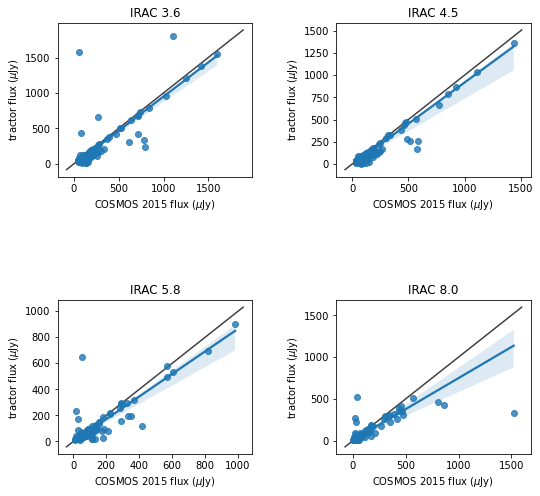

In [23]:
%%time
#plot tractor fluxes vs. catalog splash fluxes
#and hope I see a straightline with a slope of 1
#using sns regplot which plots both the data and a linear regression model fit
#this plotting tool is for visualization and not statistics, so I don't have rigorous slopes from it.
#need to still add uncertainties to the plotting and regression


#setup to plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

#ch1 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch1flux> 0) & (df.ch1flux < 2000)]
sns.regplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 3.6')


#ch2 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch2flux> 0) & (df.ch2flux < 2000)]
sns.regplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 4.5')


#ch3 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch3flux> 0) & (df.ch3flux < 2000)]

sns.regplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax3.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 5.8')


#ch4 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch4flux> 0) & (df.ch4flux < 2000)]

sns.regplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax4.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 8.0')

plt.tight_layout()


fig.set_size_inches(8, 8)

#plt.savefig('flux_comparison_IRAC.png')

#### Tractor is working; Comparison of tractor derived fluxes with COSMOS 2015 fluxes for all four Spitzer IRAC channels.  Blue points represent each of ~250 randomly chosen objects from the COSMOS 2015 catalog.  The blue line is a linear regression robust fit to the data with uncertainties shown as the light blue wedge.  The black line is a y = x line plotted to guide the eye.